In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import squareform, pdist

In [2]:
# filepath = os.path.join("..", "data", "bank-additional", "bank-additional-full.csv")
filepath = os.path.join("..", "data", "preprocessed", "bank-additional-full-preprocessed.csv")
df = pd.read_csv(filepath)
df.head()

,age,default,housing,loan,contact,n_contacts_current,pdays,n_contacts_previous,emp.var.rate,cons.price.idx,...,job_student,job_technician,job_unemployed,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree
0,56,0,0,0,0,1,999,0,1.1,93.994,...,0,0,0,1,0,0,0,0,0,0
1,57,1,0,0,0,1,999,0,1.1,93.994,...,0,0,0,0,0,0,1,0,0,0
2,37,0,1,0,0,1,999,0,1.1,93.994,...,0,0,0,0,0,0,1,0,0,0
3,40,0,0,0,0,1,999,0,1.1,93.994,...,0,0,0,0,1,0,0,0,0,0
4,56,0,0,1,0,1,999,0,1.1,93.994,...,0,0,0,0,0,0,1,0,0,0


In [3]:
df.columns

Index(['age', 'default', 'housing', 'loan', 'contact', 'n_contacts_current',
       'pdays', 'n_contacts_previous', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'subscribed', 'month_cos',
       'month_sin', 'weekday_cos', 'weekday_sin', 'poutcome_failure',
       'marital_single', 'marital_married', 'marital_divorced', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree'],
      dtype='object')

In [4]:
target = "subscribed"
features = list(set(df.columns) - {target})
numerical_features = [
    "age", "n_contacts_current", "pdays", "n_contacts_previous", "emp.var.rate",
    "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed",
    "month_cos", "month_sin", "weekday_cos", "weekday_sin"
]
categorical_features = list(set(df.columns) - {target} - set(numerical_features))

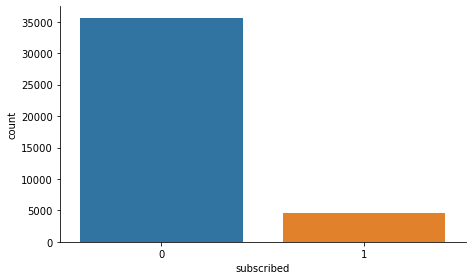

In [24]:
_ = sns.catplot(x=target, kind="count", data=df, height = 4, aspect = 1.618)

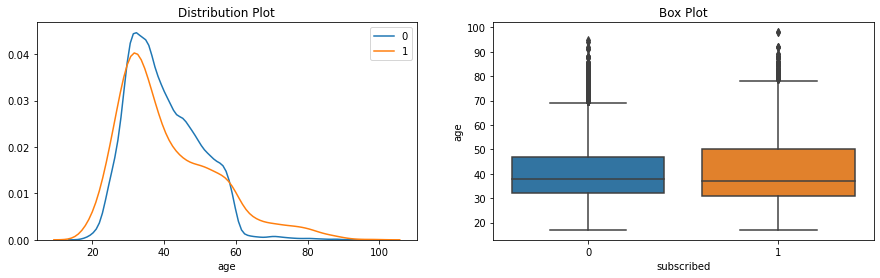

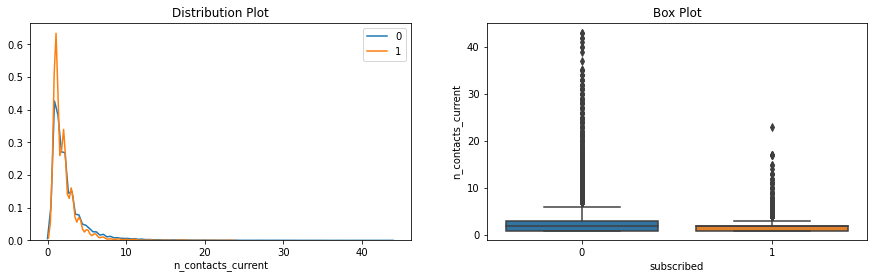

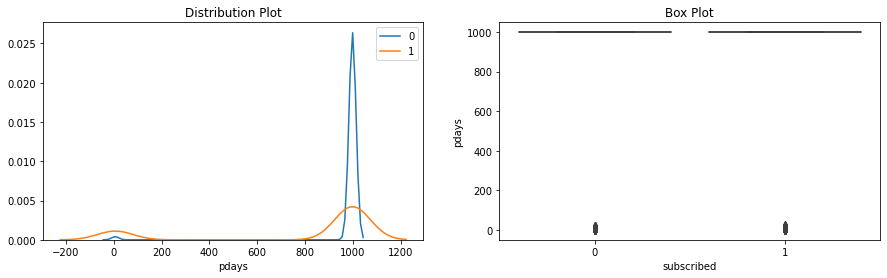

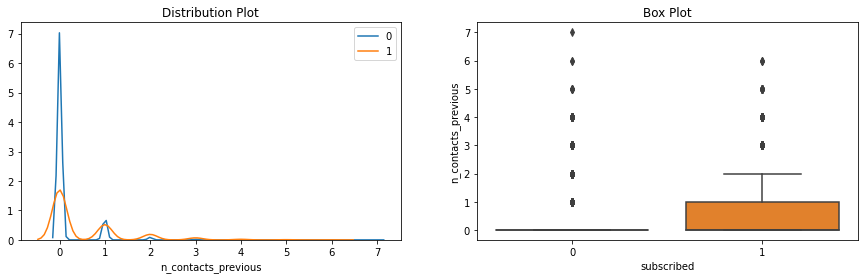

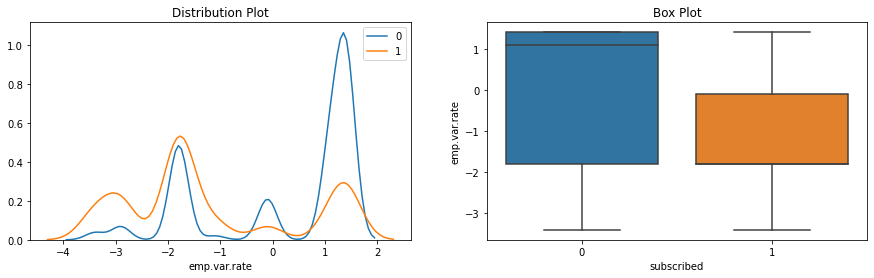

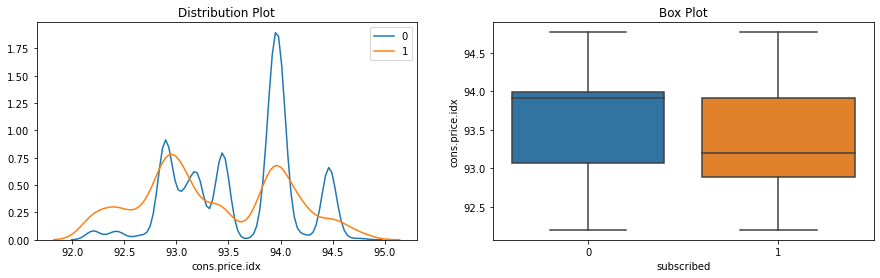

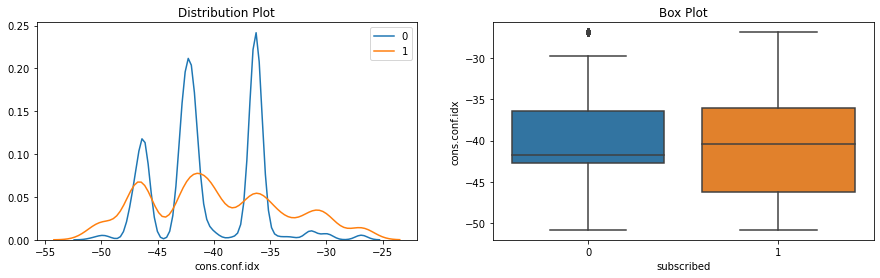

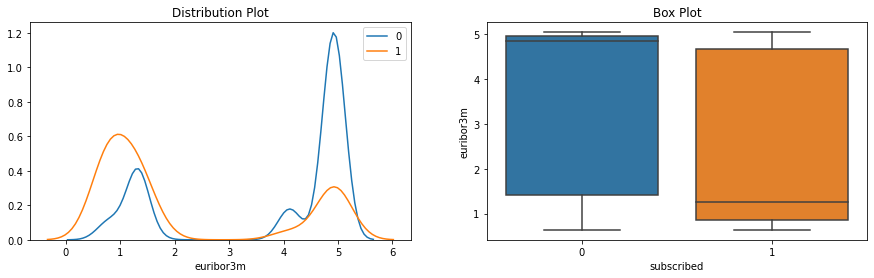

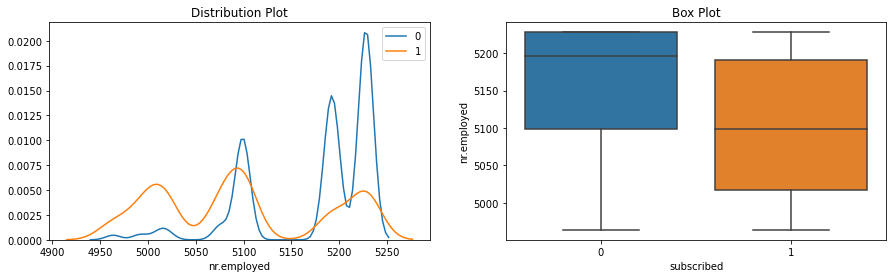

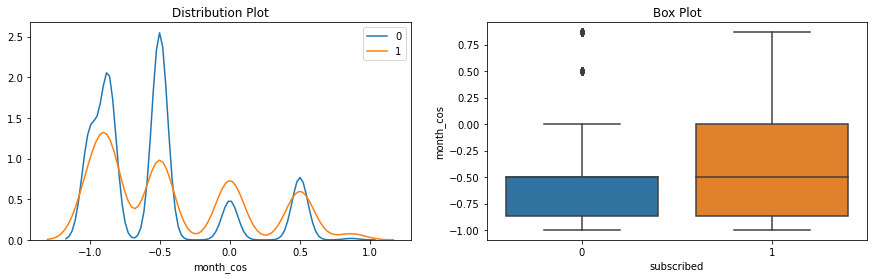

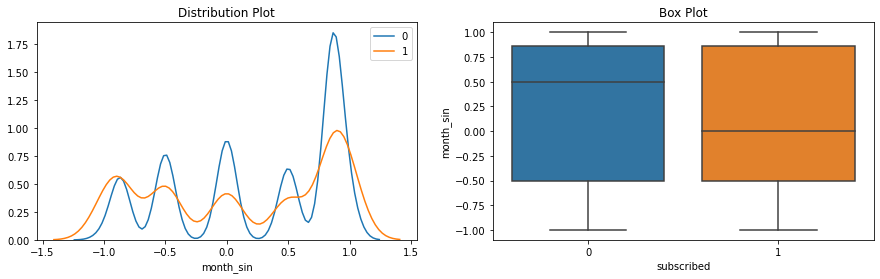

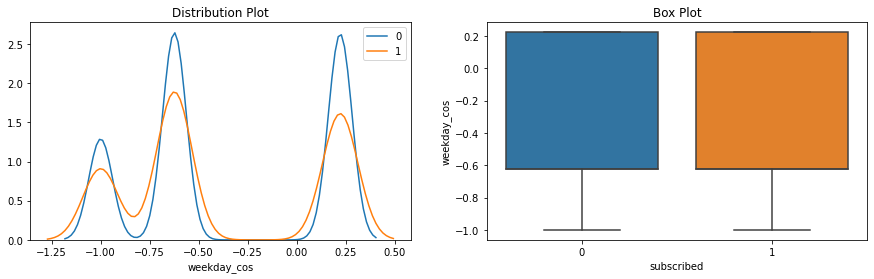

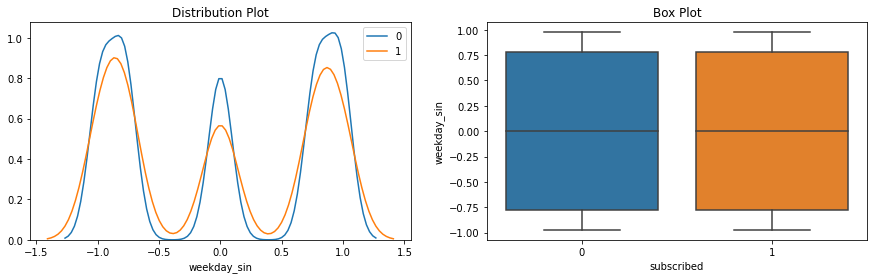

In [6]:
for col in numerical_features:
    fig, ax = plt.subplots(ncols = 2, figsize = (15, 4))
    # fig.suptitle(f"Results for {model_name if model_name else model.__class__.__name__} at test set")

    ax[0].set_title("Distribution Plot")
    sns.distplot(df.loc[df[target] == 0, col], hist = False, ax = ax[0], label = "0")
    sns.distplot(df.loc[df[target] == 1, col], hist = False, ax = ax[0], label = "1")

    ax[1].set_title("Box Plot")
    sns.boxplot(x=target, y=col, data=df, ax = ax[1])
    plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df =  pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index = df.index)
df["subscribed"] = df["subscribed"].apply(lambda x: 1 if x > 0 else 0)

In [8]:
df_negative = df[df["subscribed"] == 0]
df_positive = df[df["subscribed"] == 1]

print("negative instances:", df_negative.shape)
print("positive instances:", df_positive.shape)

negative instances: (35662, 40)
positive instances: (4533, 40)


In [9]:
def plot_outlier_distance_filter(distances, filter = 13.5, figsize = (10,4)):
    plot_data = pd.concat([distances.mean(), distances.std()], axis = 1)
    plot_data.rename(columns = {0: "mean", 1: "std"}, inplace = True)
    plot_data.sort_values(by = "mean", inplace = True)

    fig, ax = plt.subplots(figsize = figsize, ncols = 2)
    fig.suptitle("Distância média de uma observação para as demais")

    ax[0].plot(plot_data.reset_index()["mean"])
    ax[0].axhline(filter, linestyle = "--", color = "k")
    ax[0].set_title("Antes do filtro")

    filtered = plot_data[plot_data["mean"] < filter]
    ax[1].plot(filtered.reset_index()["mean"])
    ax[1].set_title("Após o filtro")

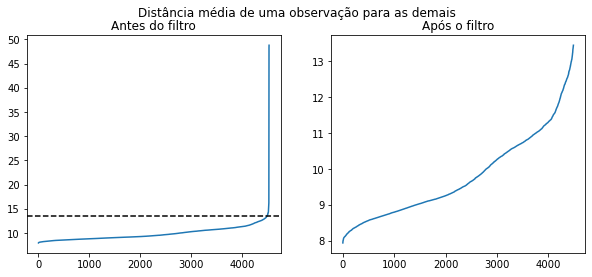

In [10]:
positive_distances = squareform(pdist(df_positive[features]))
positive_distances = pd.DataFrame(positive_distances, index = df_positive.index, columns = df_positive.index)
plot_outlier_distance_filter(positive_distances, filter = 13.5, figsize = (10,4))

Wall time: 4.27 s


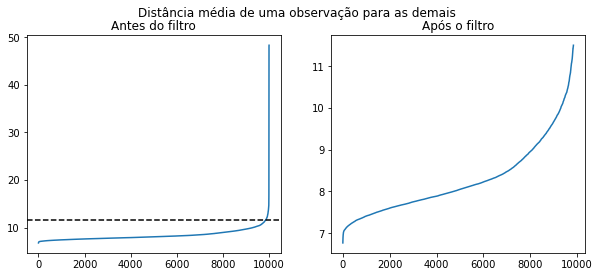

In [11]:
%%time
negative_distances = squareform(pdist(df_negative[features].sample(10000)))
negative_distances = pd.DataFrame(negative_distances)
plot_outlier_distance_filter(negative_distances, filter = 11.5, figsize = (10,4))

In [12]:
keep_indexes = []
positive_distances = squareform(pdist(df_positive[features]))
positive_distances = pd.DataFrame(positive_distances, index = df_positive.index, columns = df_positive.index).mean()
keep_indexes.extend(positive_distances[positive_distances < 13.5].index.values)

for chunk in np.array_split(df_negative, 7):
    chunk_distances = squareform(pdist(chunk[features]))
    chunk_distances = pd.DataFrame(chunk_distances, index = chunk.index, columns = chunk.index).mean()
    keep_indexes.extend(chunk_distances[chunk_distances < 11.5].index.values)

In [13]:
print(f"Removed {df.shape[0] - len(keep_indexes)} instances")

Removed 326 instances


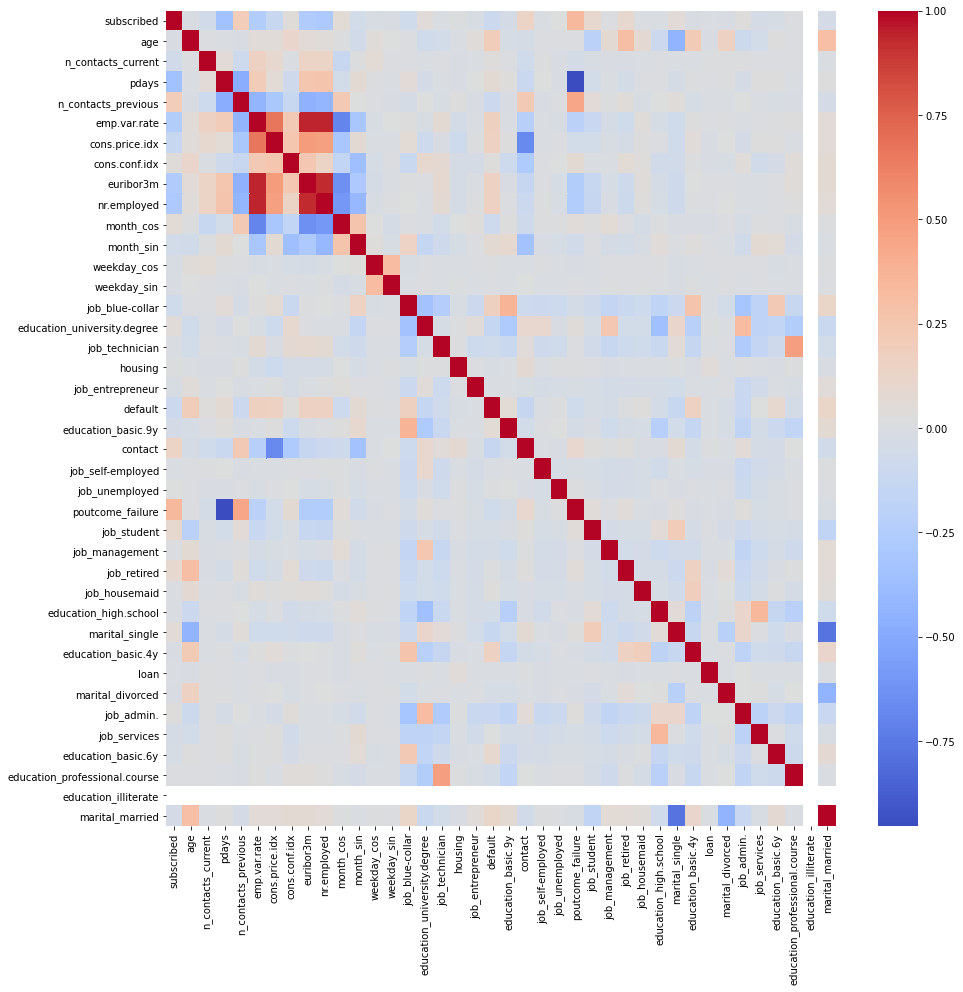

In [28]:
filtered_df = df.loc[keep_indexes, [target] + numerical_features + categorical_features]
corr = filtered_df.corr(method = "spearman")

plt.figure(figsize = (15, 15))
_ = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap = "coolwarm")

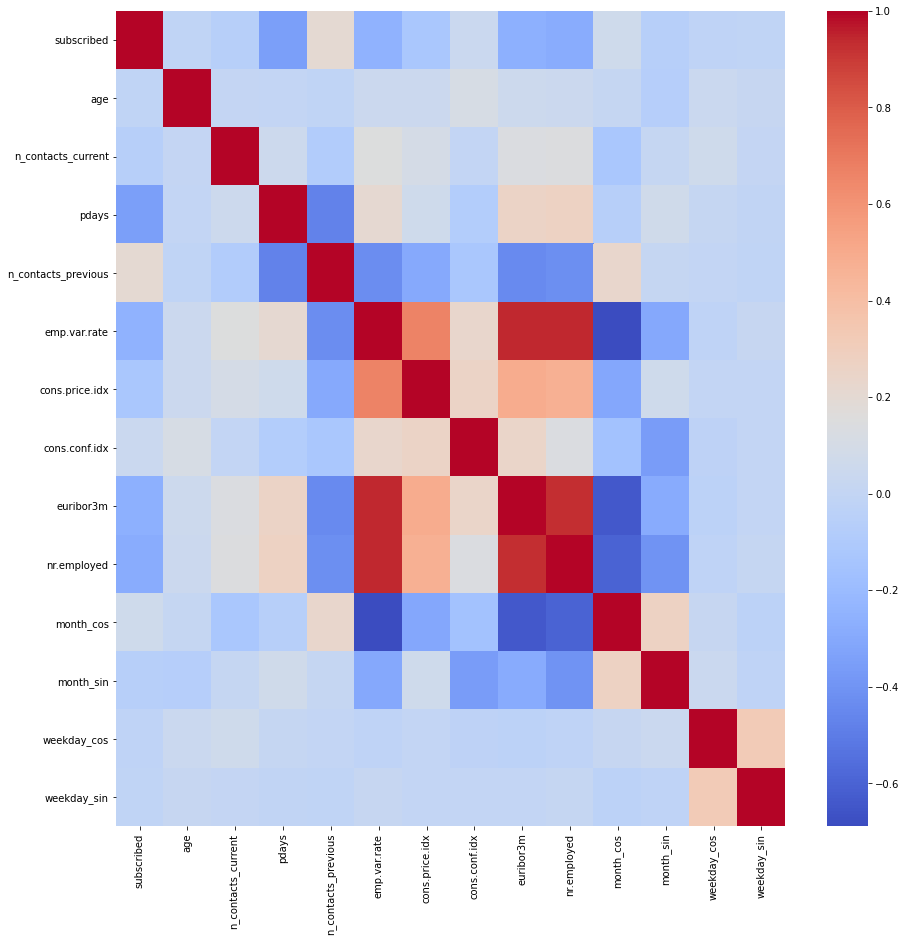

In [25]:
filtered_df = df.loc[keep_indexes, [target] + numerical_features]
corr = filtered_df.corr(method = "spearman")

plt.figure(figsize = (15, 15))
_ = sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap = "coolwarm")

In [16]:
if not os.path.exists(os.path.join("..", "data", "preprocessed")): os.mkdir(os.path.join("..", "data", "preprocessed"))
filtered_df.to_csv(os.path.join("..", "data", "preprocessed", "bank-additional-full-preprocessed-clean.csv"), index = False)